In [8]:
#First we import the necessary libraries and load the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from google.colab import files
import shutil

# Upload file interactively
uploaded = files.upload()

# Move the uploaded file to /content/sample_data
for filename in uploaded.keys():
    shutil.move(filename, '/content/sample_data/' + filename)

print("File uploaded and moved to /content/sample_data/")


df = pd.read_csv('/content/sample_data/RTA Dataset.csv')


Saving RTA Dataset.csv to RTA Dataset.csv
File uploaded and moved to /content/sample_data/


Shape of the dataset: (12316, 32)

Missing Values:
Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_seve

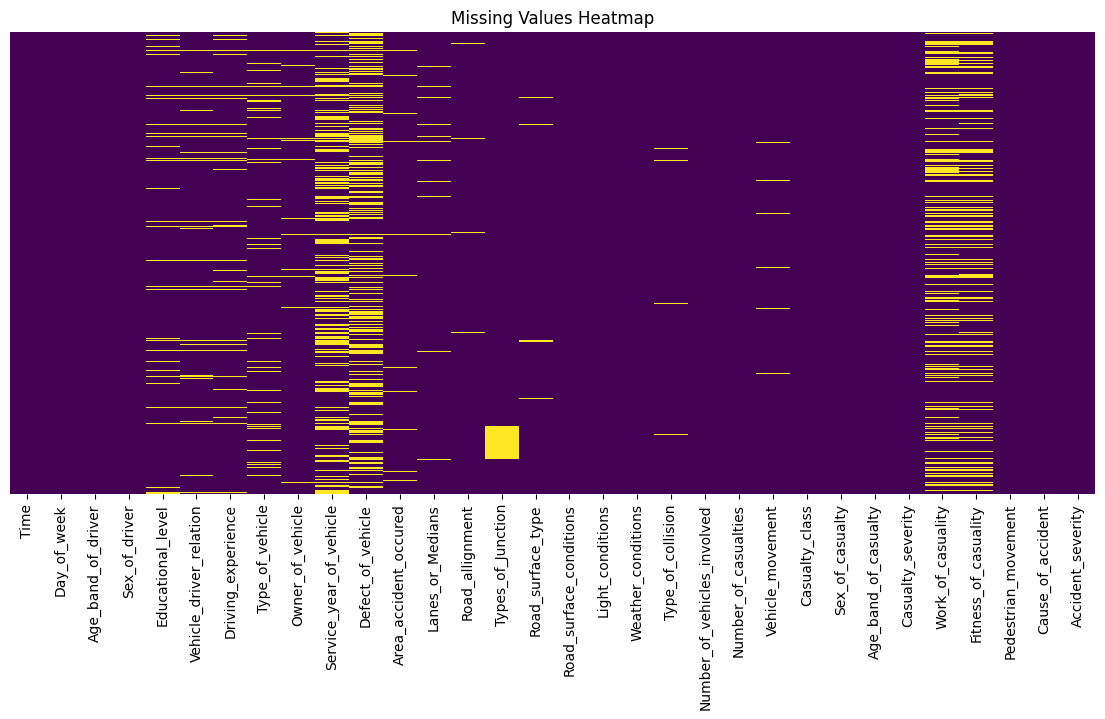

In [9]:
# We provide some general dataset info
print("Shape of the dataset:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


In [10]:
# Handling Missing Values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())


print("\nMissing values after cleaning:")
print(df.isnull().sum().sum())



Missing values after cleaning:
0


In [11]:
# We then encode Categorical Variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


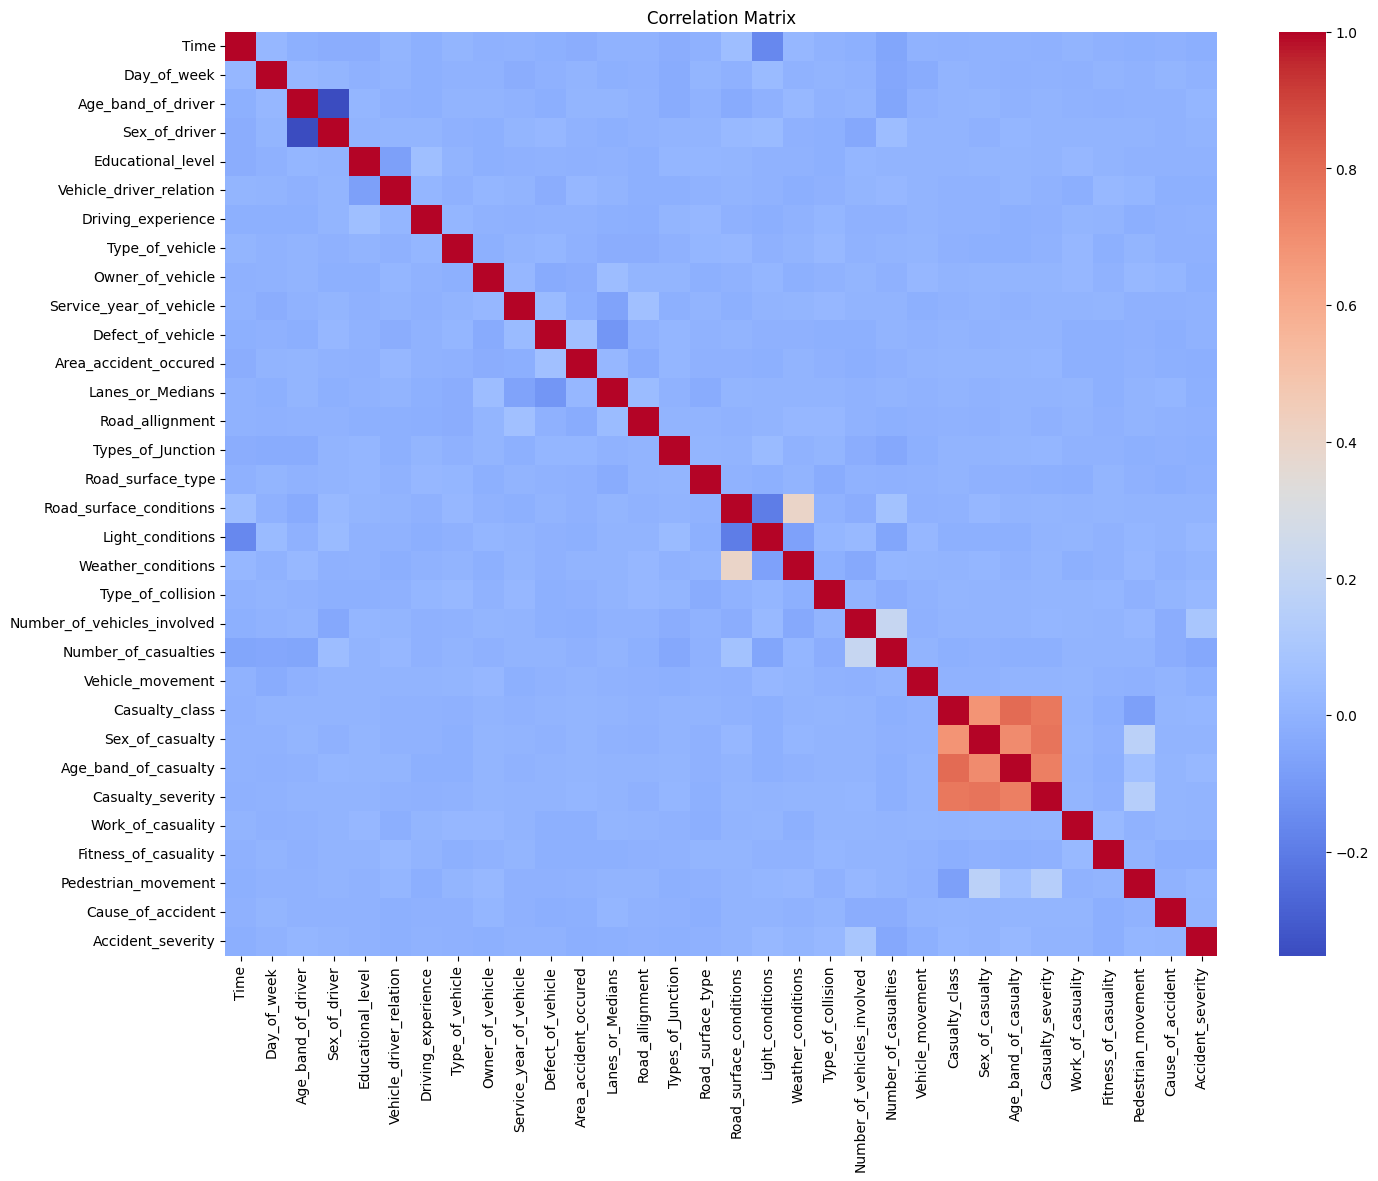

In [12]:
# Correlation Matrix
plt.figure(figsize=(16, 12))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


In [15]:
selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

# Subset dataset
df = df[selected_features + [target]].copy()

# Fill missing values again just in case
for col in df.columns:
    if df[col].dtype == 'object':
        df.loc[:, col] = df[col].fillna('Unknown')
    else:
        df.loc[:, col] = df[col].fillna(df[col].mean())

# Label encode all again (for safety)
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


# Prepare features and target
X = df.drop(target, axis=1)
y = df[target]

# Apply SMOTE on the whole dataset BEFORE splitting
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Original dataset shape: {X.shape}, {y.shape}")
print(f"After SMOTE dataset shape: {X_resampled.shape}, {y_resampled.shape}")

# Train-test split on resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Original dataset shape: (12316, 23), (12316,)
After SMOTE dataset shape: (31245, 23), (31245,)



XGBoost Best Parameters: {'learning_rate': 0.5, 'max_depth': 12, 'n_estimators': 400}
XGBoost Best CV Accuracy: 0.9208083006250578

XGBoost Test Accuracy: 0.9240452314913591
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3124
           1       0.90      0.88      0.89      3125
           2       0.88      0.90      0.89      3125

    accuracy                           0.92      9374
   macro avg       0.92      0.92      0.92      9374
weighted avg       0.92      0.92      0.92      9374



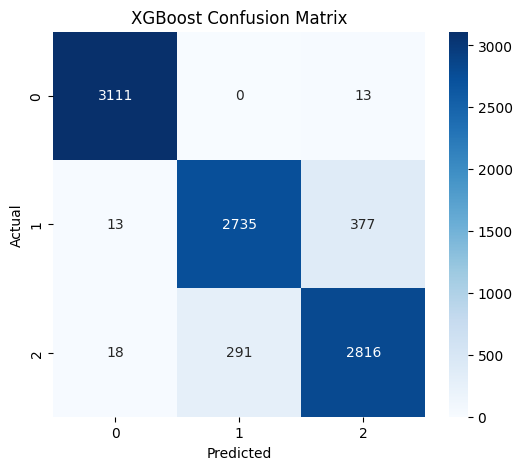

In [16]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'max_depth': [7, 10, 12],
    'learning_rate': [0.01, 0.1, 0.5]
}

xgb_model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42)

grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=4, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_
print("\nXGBoost Best Parameters:", grid_search_xgb.best_params_)
print("XGBoost Best CV Accuracy:", grid_search_xgb.best_score_)

# Predict and evaluate on test set
y_pred_xgb = best_xgb.predict(X_test)
print("\nXGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

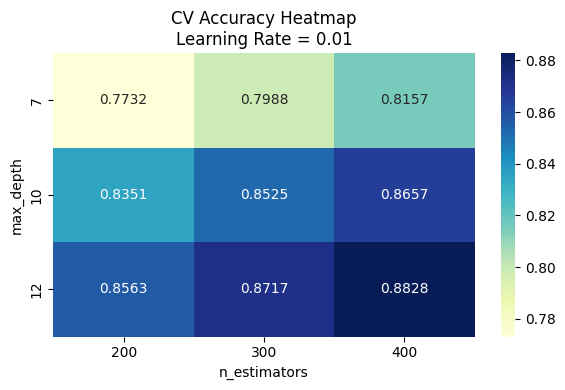

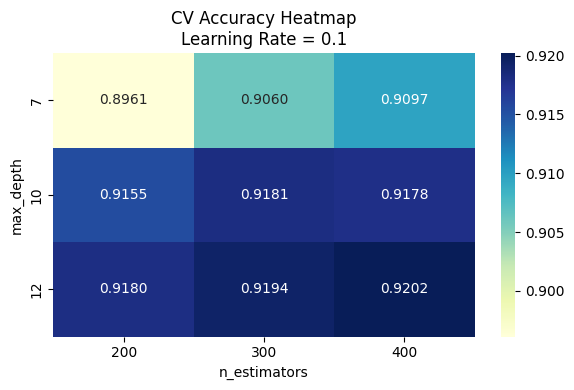

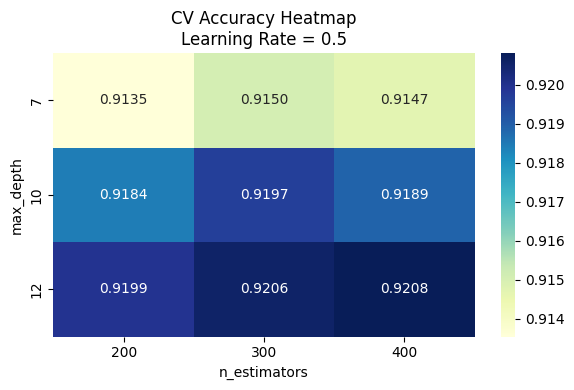

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)

# Plot heatmaps: one for each learning_rate value
for lr in param_grid_xgb['learning_rate']:
    subset = results_xgb[results_xgb['param_learning_rate'] == lr]

    heatmap_data = subset.pivot(index='param_max_depth',
                                columns='param_n_estimators',
                                values='mean_test_score')

    plt.figure(figsize=(6, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='YlGnBu')
    plt.title(f'CV Accuracy Heatmap\nLearning Rate = {lr}')
    plt.xlabel('n_estimators')
    plt.ylabel('max_depth')
    plt.tight_layout()
    plt.show()


Fitting 4 folds for each of 81 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 21871, number of used features: 23
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

Best Parameters: {'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 300, 'num_leaves': 63}
Best CV Accuracy: 0.9175619488026114


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Test Accuracy: 0.9188180072541071
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3124
           1       0.91      0.85      0.88      3125
           2       0.86      0.91      0.88      3125

    accuracy                           0.92      9374
   macro avg       0.92      0.92      0.92      9374
weighted avg       0.92      0.92      0.92      9374



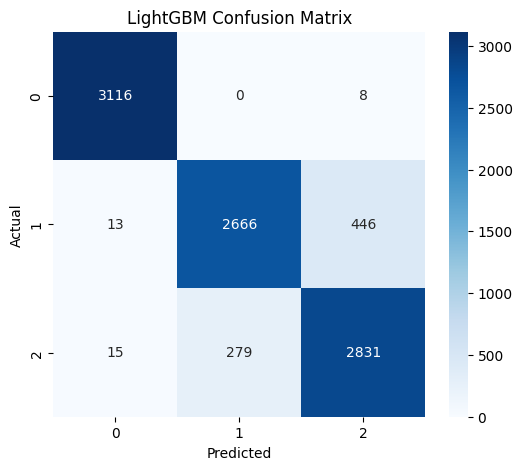

In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
param_grid = {
   'n_estimators': [100, 200, 300],
   'max_depth': [10, 20, 30],
   'learning_rate': [0.01, 0.05, 0.1],
   'num_leaves': [31, 50, 63]
}

lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on scaled training data
grid_search.fit(X_train_scaled, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Predict on test data
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test_scaled)

print("\nLightGBM Test Accuracy:", accuracy_score(y_test, y_pred))
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


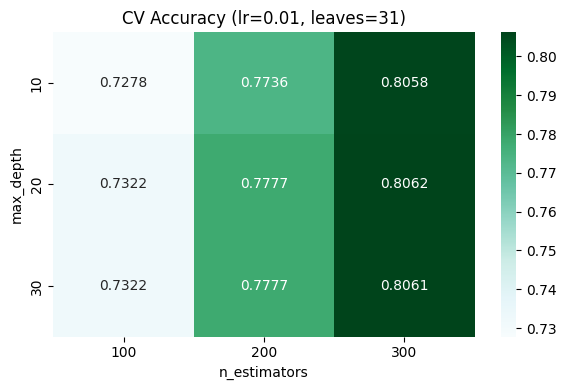

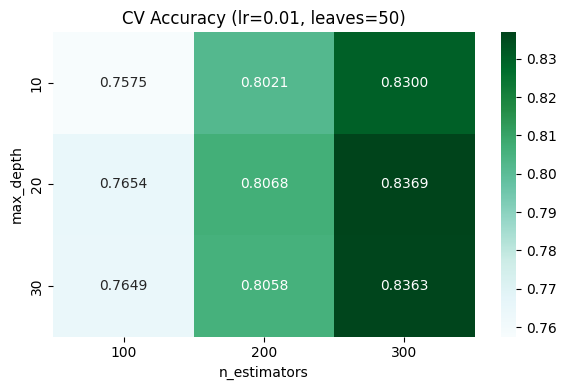

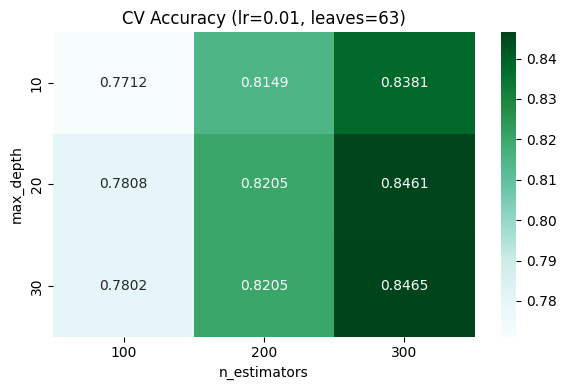

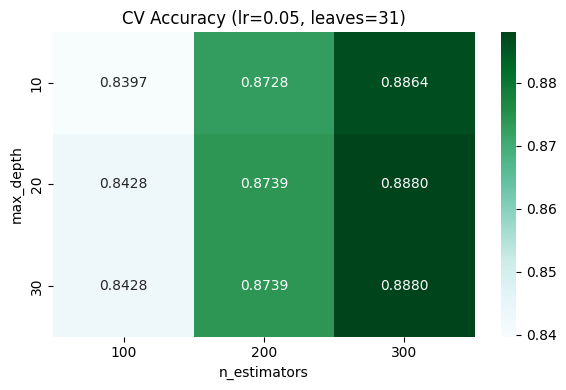

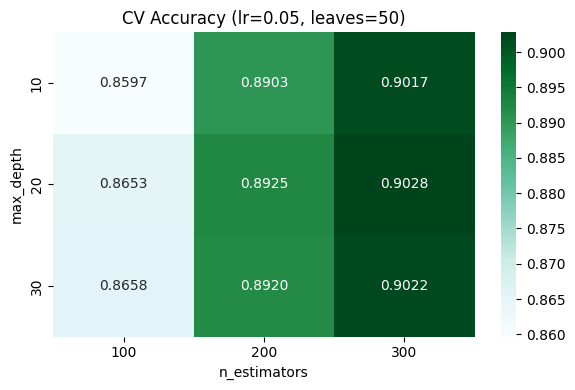

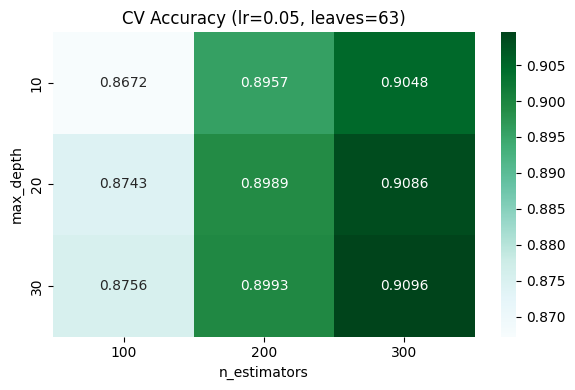

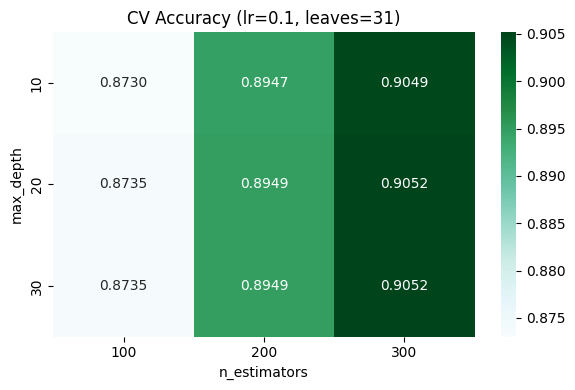

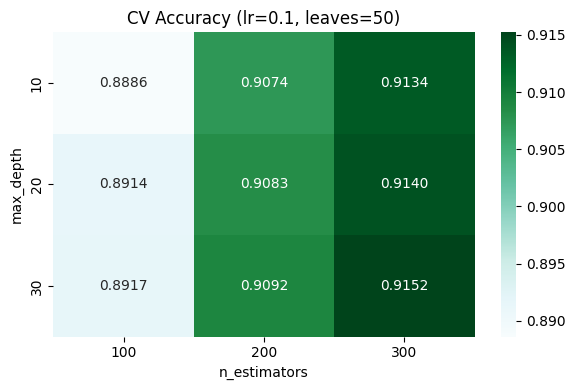

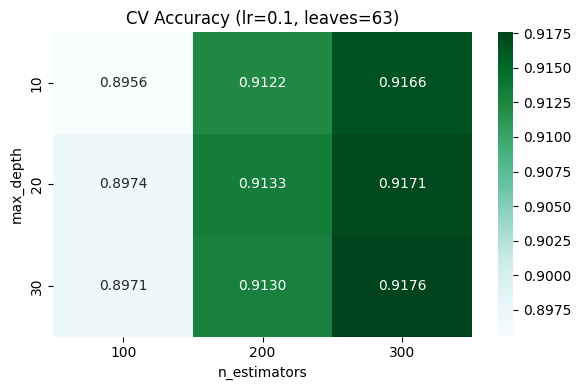

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to DataFrame
results_lgbm = pd.DataFrame(grid_search.cv_results_)

# Loop through slices of fixed learning_rate and num_leaves
for lr in param_grid['learning_rate']:
    for leaves in param_grid['num_leaves']:
        subset = results_lgbm[
            (results_lgbm['param_learning_rate'] == lr) &
            (results_lgbm['param_num_leaves'] == leaves)
        ]

        if not subset.empty:
            heatmap_data = subset.pivot(index='param_max_depth',
                                         columns='param_n_estimators',
                                         values='mean_test_score')

            plt.figure(figsize=(6, 4))
            sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='BuGn')
            plt.title(f'CV Accuracy (lr={lr}, leaves={leaves})')
            plt.xlabel('n_estimators')
            plt.ylabel('max_depth')
            plt.tight_layout()
            plt.show()
